In [25]:
# Import the required modules.
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import corner

from astropy.cosmology import Planck18 as cosmo    # Import a different cosmology as required.

from synthesizer.filters import FilterCollection
from synthesizer.grid import Grid
from synthesizer.parametric.sfzh import SFH, ZH, generate_sfzh
from synthesizer.parametric.galaxy import Galaxy
from unyt import Myr,Gyr    # Import additonal units as required.
from synthesizer.igm import Madau96, Inoue14

import bagpipes as pipes

## Producing synthetic observations with Synthesizer

In [26]:
# grid_name = "test_grid"
# grid_dir = "../synthesizer/tests/test_grid"
grid_name = "cb07"
grid_dir = "../grids"
grid = Grid(grid_name, grid_dir=grid_dir)
print(grid)

------------------------------
SUMMARY OF GRID
log10age: [ 5.          5.          5.14998846  5.20000187  5.25000503  5.3000082
  5.3499959   5.40000235  5.45000263  5.50000307  5.55000809  5.60000309
  5.65000623  5.7000024   5.74999898  5.80000183  5.85000259  5.90000097
  5.95000442  6.          6.01998816  6.04000864  6.06001754  6.08001285
  6.09999123  6.12001425  6.14000495  6.15998805  6.18001112  6.20000187
  6.22000343  6.23999979  6.2599998   6.28000895  6.3000082   6.3200008
  6.34000762  6.36000613  6.37999404  6.40000235  6.42000528  6.43999547
  6.45999526  6.48000694  6.50000307  6.51999853  6.54000394  6.56000233
  6.58000069  6.60000309  6.62000064  6.64000415  6.66000172  6.67999992
  6.7000024   6.7200021   6.73999931  6.76000005  6.7800003   6.80000183
  6.81999773  6.83999939  6.86000242  6.88000139  6.90000097  6.91999803
  6.93999821  6.9599996   6.97999882  7.          7.01998816  7.04000864
  7.06001754  7.08001285  7.09999123  7.11998131  7.14000495  7.15998

In [27]:
# Generate a constant metal enrichment history.

#-----------------------------------------
log10z = -2.0    # Change the metalicity.
#-----------------------------------------

Z_p = {'log10Z': log10z}
Zh = ZH.deltaConstant(Z_p)
print(Zh)

----------
SUMMARY OF PARAMETERISED METAL ENRICHMENT HISTORY
<class 'synthesizer.parametric.sfzh.ZH.deltaConstant'>
log10Z: -2.0
----------



In [48]:
# Generate an exponential SFH.

#------------------------------------------------------------------------
tau = 100 * Myr    # Change the timescale of SFR decrease.
max_age = 200 * Myr    # Change the time since SF began. 
stellar_mass = 1E8    # Change the stellar mass to be generated [M_sol].
#------------------------------------------------------------------------

sfh_p = {'tau': tau, 'max_age': max_age}    # Use 'unyt' to define units.
sfh = SFH.Exponential(sfh_p) 
print(sfh)

# Bin with the enrichment history.
sfhz = generate_sfzh(grid.log10age, grid.metallicity, sfh, Zh, stellar_mass=stellar_mass)
print(sfhz)


----------
SUMMARY OF PARAMETERISED STAR FORMATION HISTORY
<class 'synthesizer.parametric.sfzh.SFH.Exponential'>
tau: 100 Myr
max_age: 200 Myr
median age: 69.00 Myr
mean age: 99.50 Myr
----------

----------
SUMMARY OF BINNED SFZH
median age: 71.87 Myr
mean age: 99.89 Myr
mean metallicity: 0.0080
----------



In [29]:
# Create a galaxy object from the binned SF and enrichment history.
galaxy = Galaxy(sfhz)

# Generate spectra using a simple screen dust model 
Av = 0.2    # Change the absolute attenuation in the V band [mag].
sed = galaxy.get_spectra_screen(grid, tau_v=Av/1.086)

# Calculate the observed frame spectra based on assumed cosmology and IGM treatment.
z = 8    # Change the observed redshift of the galaxy.
igm = Madau96()    # Chnage the treatment of the IGM.
cosmology = cosmo    # Change the assumed cosmology.
sed.get_fnu(cosmology, z, igm=igm)

Decide on some filters and intialise the FilterCollection object

In [30]:
# Select the filters to generate synthetic observations for. Use the full set of NIRCam wide filters in addition to F410M:
filter_codes = [f'JWST/NIRCam.{f}' for f in ['F070W','F090W','F115W', 'F150W','F200W', 'F277W', 'F356W', 'F410M', 'F444W']]
fc = FilterCollection(filter_codes, new_lam=grid.lam)

In [31]:
# Measure the broadband fluxes.
fluxes = sed.get_broadband_fluxes(fc)

for filter, flux in fluxes.items():
    print(f'{filter}: {flux:.2f}')


JWST/NIRCam.F070W: 0.00 nJy
JWST/NIRCam.F090W: 0.02 nJy
JWST/NIRCam.F115W: 5.07 nJy
JWST/NIRCam.F150W: 6.83 nJy
JWST/NIRCam.F200W: 7.31 nJy
JWST/NIRCam.F277W: 7.58 nJy
JWST/NIRCam.F356W: 9.66 nJy
JWST/NIRCam.F410M: 9.31 nJy
JWST/NIRCam.F444W: 12.89 nJy


emergent


/Users/sw376/Dropbox/Research/projects/gradnet23_exgal_sed/synthesizer/synthesizer/igm.py:206: RuntimeWarning: overflow encountered in exp
  t = np.exp(-tau)


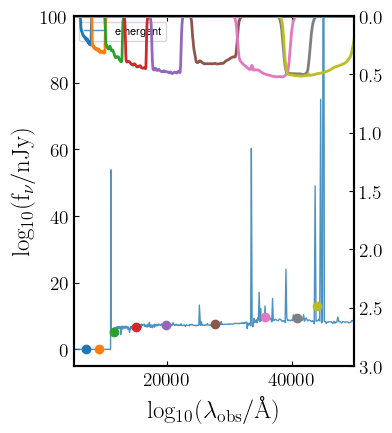

In [32]:
# Plot the observed spectra and the measured broadband fluxes.
fig, ax = galaxy.plot_observed_spectra(cosmo, z, fc=fc, spectra_to_plot=['emergent'])
ax.set_xlim(5000,50000)
ax.set_ylim(-5,100)
plt.show()

Convert fluxes to micro jansky for use in BAGPIPES.

In [33]:
fluxes_array = np.array([flux.to('uJy').value for flux in fluxes.values()])
print(fluxes_array)

[1.20542891e-22 2.00855377e-05 5.07097136e-03 6.82995724e-03
 7.30994134e-03 7.57766217e-03 9.65732028e-03 9.31154256e-03
 1.28869053e-02]


Define F200W SNR and use to calculate the noise

In [34]:
snr = 20
noise = fluxes['JWST/NIRCam.F200W'].to('uJy').value/snr
print(noise)

0.00036549706687992396


Apply gaussian noise to the fluxes

In [35]:
errors_array = noise*np.ones(len(fluxes_array))

fluxes_array += errors_array*normal()
print(fluxes_array)

[1.74605468e-05 3.75460845e-05 5.08843190e-03 6.84741778e-03
 7.32740188e-03 7.59512272e-03 9.67478083e-03 9.32900310e-03
 1.29043659e-02]


Print S/N in each band

In [36]:
for i,f in enumerate(filter_codes):
    print(f, fluxes_array[i]/errors_array[i])

JWST/NIRCam.F070W 0.047772057371953947
JWST/NIRCam.F090W 0.1027260898747266
JWST/NIRCam.F115W 13.921950037356346
JWST/NIRCam.F150W 18.734535524115042
JWST/NIRCam.F200W 20.047772057371954
JWST/NIRCam.F277W 20.78025626874647
JWST/NIRCam.F356W 26.47020100745181
JWST/NIRCam.F410M 25.524153125261403
JWST/NIRCam.F444W 35.30634588257761


## Recovering model spectra with BAGPIPES

In [37]:

# bagpipes requires a list of paths to the filters, unfortunately the SVO names its filters and the transmission curves differently. Hence the need for the below. As part of the installation these filters were provided and installed where bagpipes needs them

# Defining the same set of filters, in the same order.
# These should be downloaded from the SVO Filter Service and placed in '/bagpipes/filters'.
bagpipes_filters = [f"filters/{filter.replace('/','_')}.dat" for filter in filter_codes]
print(bagpipes_filters)


['filters/JWST_NIRCam.F070W.dat', 'filters/JWST_NIRCam.F090W.dat', 'filters/JWST_NIRCam.F115W.dat', 'filters/JWST_NIRCam.F150W.dat', 'filters/JWST_NIRCam.F200W.dat', 'filters/JWST_NIRCam.F277W.dat', 'filters/JWST_NIRCam.F356W.dat', 'filters/JWST_NIRCam.F410M.dat', 'filters/JWST_NIRCam.F444W.dat']


In [38]:
# Bagpipes needs a function that accepts an ID and returns corresponding photometry. 
# Creating a dummy function that just put the photometry into the correct form.

def get_photometry(ID, fluxes = fluxes_array, errors = errors_array):

    photometry = np.c_[fluxes, errors]

    return photometry

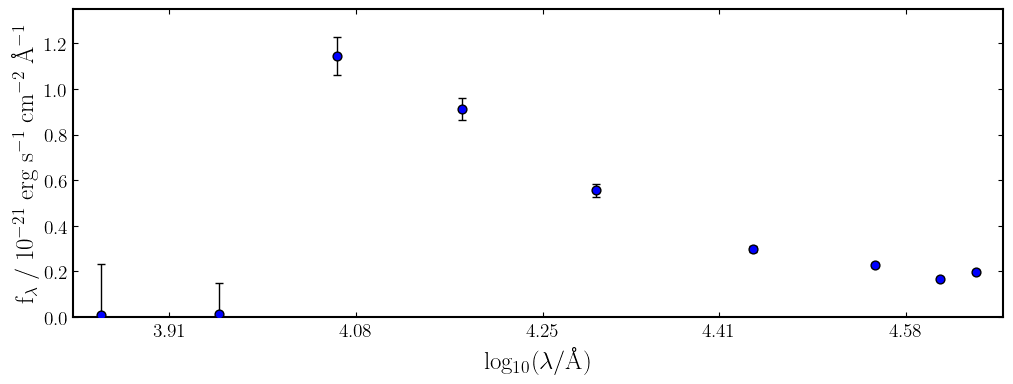

In [39]:
# Plot the measured photometry as an SED.
galaxy = pipes.galaxy("1", get_photometry, spectrum_exists=False, filt_list=bagpipes_filters)
fig = galaxy.plot()

In [40]:
# Define the parameters to be used in the fit.
# A single value fixes the value, a range sets the lower and upper bounds.
# The parameters used here are taken from Austin et al. (2023) looking for high-redhisft galaxies.

fit_info = {}                   

# Dust attenuation law.
dust = {}                         
dust["type"] = "Calzetti"    # The dust law to assume.         
dust["Av"] = (0,6)    # Absolute attenuation in the V band in magnitudes.          
fit_info["dust"] = dust

# SFH:
# Exponential.
exponential = {}
exponential["massformed"] = (5,12)    # Log_10 total stellar mass formed in Solar masses.
exponential["metallicity"] = (1e-4,1)    # Metallicity in old Solar units, i.e. Z_sol = 0.02.
exponential["age"] = (0,15)    # Time since star formation began in Gyr.
exponential["tau"] = (0.01,15)    # Timescale of exponential decrease in Gyr.
#exponential["tauprior"] = "log_10"    # Add priors using component["parameterprior"] = "<prior>".
fit_info['exponential'] = exponential

# Nubular:
nebular = {}
nebular["logU"] = -2    # Log_10 of the ionization parameter. Fixed as Synthesizer assumes -2, the bagpipes upper limit.
fit_info["nebular"] = nebular

# Redshift.
fit_info["redshift"] = z    # Fixed redshift to true value.

In [41]:
import os
os.system('rm -rf pipes')

# Fit the model to the measured photometry.
# This will create a file called <ID>.h5 in "bagpipes/pipes/posterior". 
# If you are rerunning with the same ID, delete the file first or it will load the previous result. Or set 'run' to a different name.

# If this begins to throw a lot of errors, restart the kernel quickly or it will make the code unresponsive.
# This appears to happen if you choose an invalid range of parameters.
# "MultiNest Warning!" is fine.
fit = pipes.fit(galaxy, fit_info, run = 'fixed_z')
fit.fit(verbose=False)


Bagpipes: fitting object 1

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    5
 *****************************************************

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the prior.

 MultiNest Warning!
 Parameter            2  of mode            1  is converging towards the edge of the pr

In [42]:
# Print the fitted values.
fit._print_results()

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.364      0.463      0.558
exponential:age                0.041      0.068      0.110
exponential:massformed         7.908      8.017      8.124
exponential:metallicity        0.350      0.551      0.713
exponential:tau                2.642      7.518     12.616




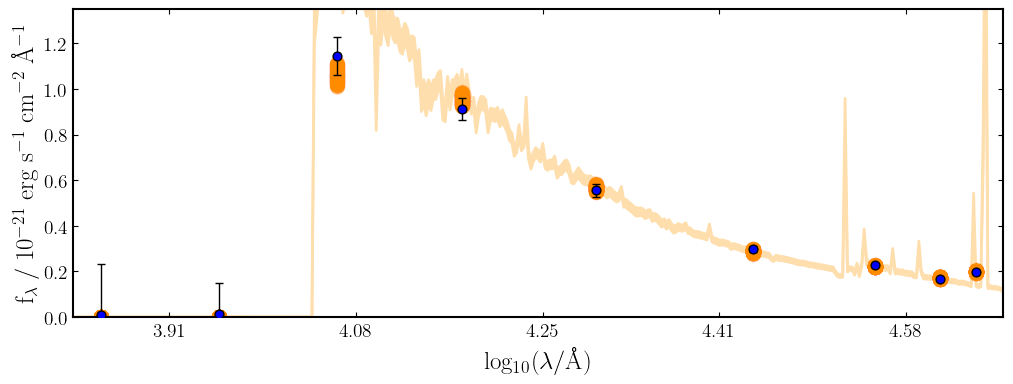

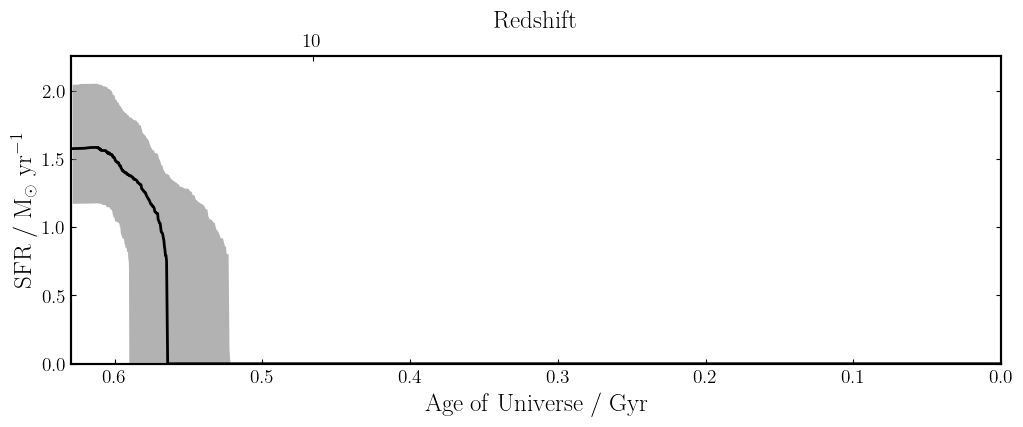

In [43]:
# Can use built in functions to plot SEDs, SFHs and corner plots.
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)

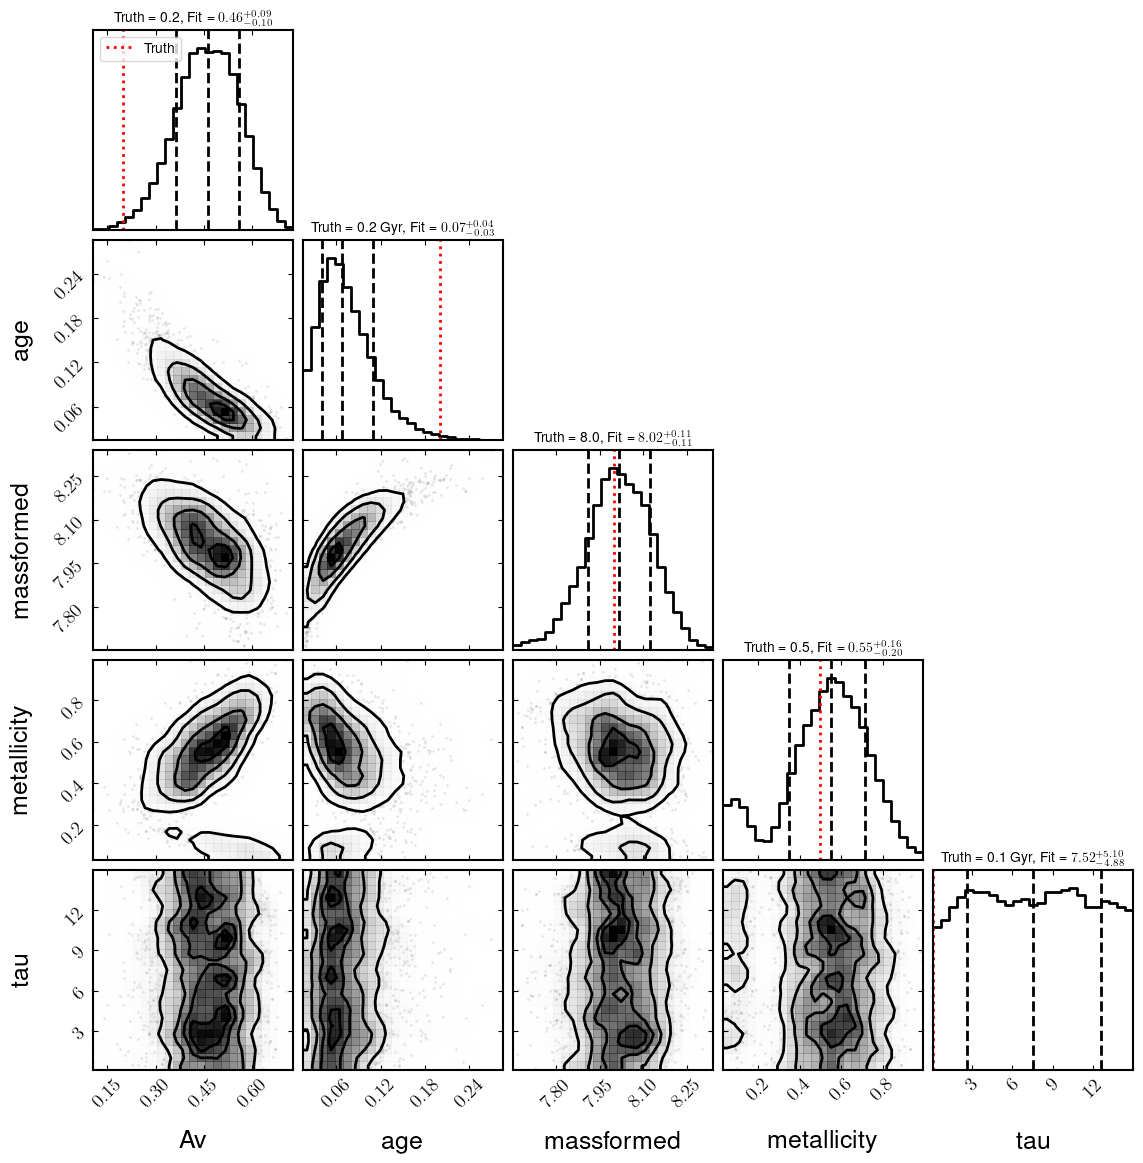

In [44]:
# Or write your own function if you want more freedom.

samples = np.copy(fit.posterior.samples2d)

truth = [Av,max_age.to(Gyr),np.log10(stellar_mass),(10**log10z)/0.02,tau.to(Gyr)]
titles = ['Truth = '+str(value)+', Fit' for value in truth]
labels = [label.split(':')[1] for label in fit.fitted_model.params]

# Make the corner plot
fig= corner.corner(samples, labels=labels, titles = titles,quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 10},
                    smooth=1., smooth1d=1., bins=25)

axes = [0,6,12,18,24]
for value, axis in zip(truth,axes):
    fig.axes[axis].axvline(value, color = 'red', linestyle = ':',label = 'Truth')
    fig.axes[0].legend()

plt.show()
plt.close(fig)

In [45]:
# Lets try fitting without knowing the redshift, as is often the case.

fit_info["redshift"] = (0,10)

fit = pipes.fit(galaxy, fit_info, run = 'free_z')
fit.fit(verbose=False)


Bagpipes: fitting object 1

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =    6
 *****************************************************

Completed in 150.6 seconds.
 ln(ev)=   439.87233804835120      +/-  0.19947650522290272     
 Total Likelihood Evaluations:       116953
 Sampling finished. Exiting MultiNest

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.405      0.484      0.556
exponential:age                0.040      0.061      0.096
exponential:massformed         7.882      7.995      8.106
exponential:metallicity        0.422      0.573      0.729
exponential:tau                3.106      8.298     12.921
redshift                  

In [46]:
# Print the fitted values.
fit._print_results()

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.405      0.484      0.556
exponential:age                0.040      0.061      0.096
exponential:massformed         7.882      7.995      8.106
exponential:metallicity        0.422      0.573      0.729
exponential:tau                3.106      8.298     12.921
redshift                       7.844      7.914      8.016




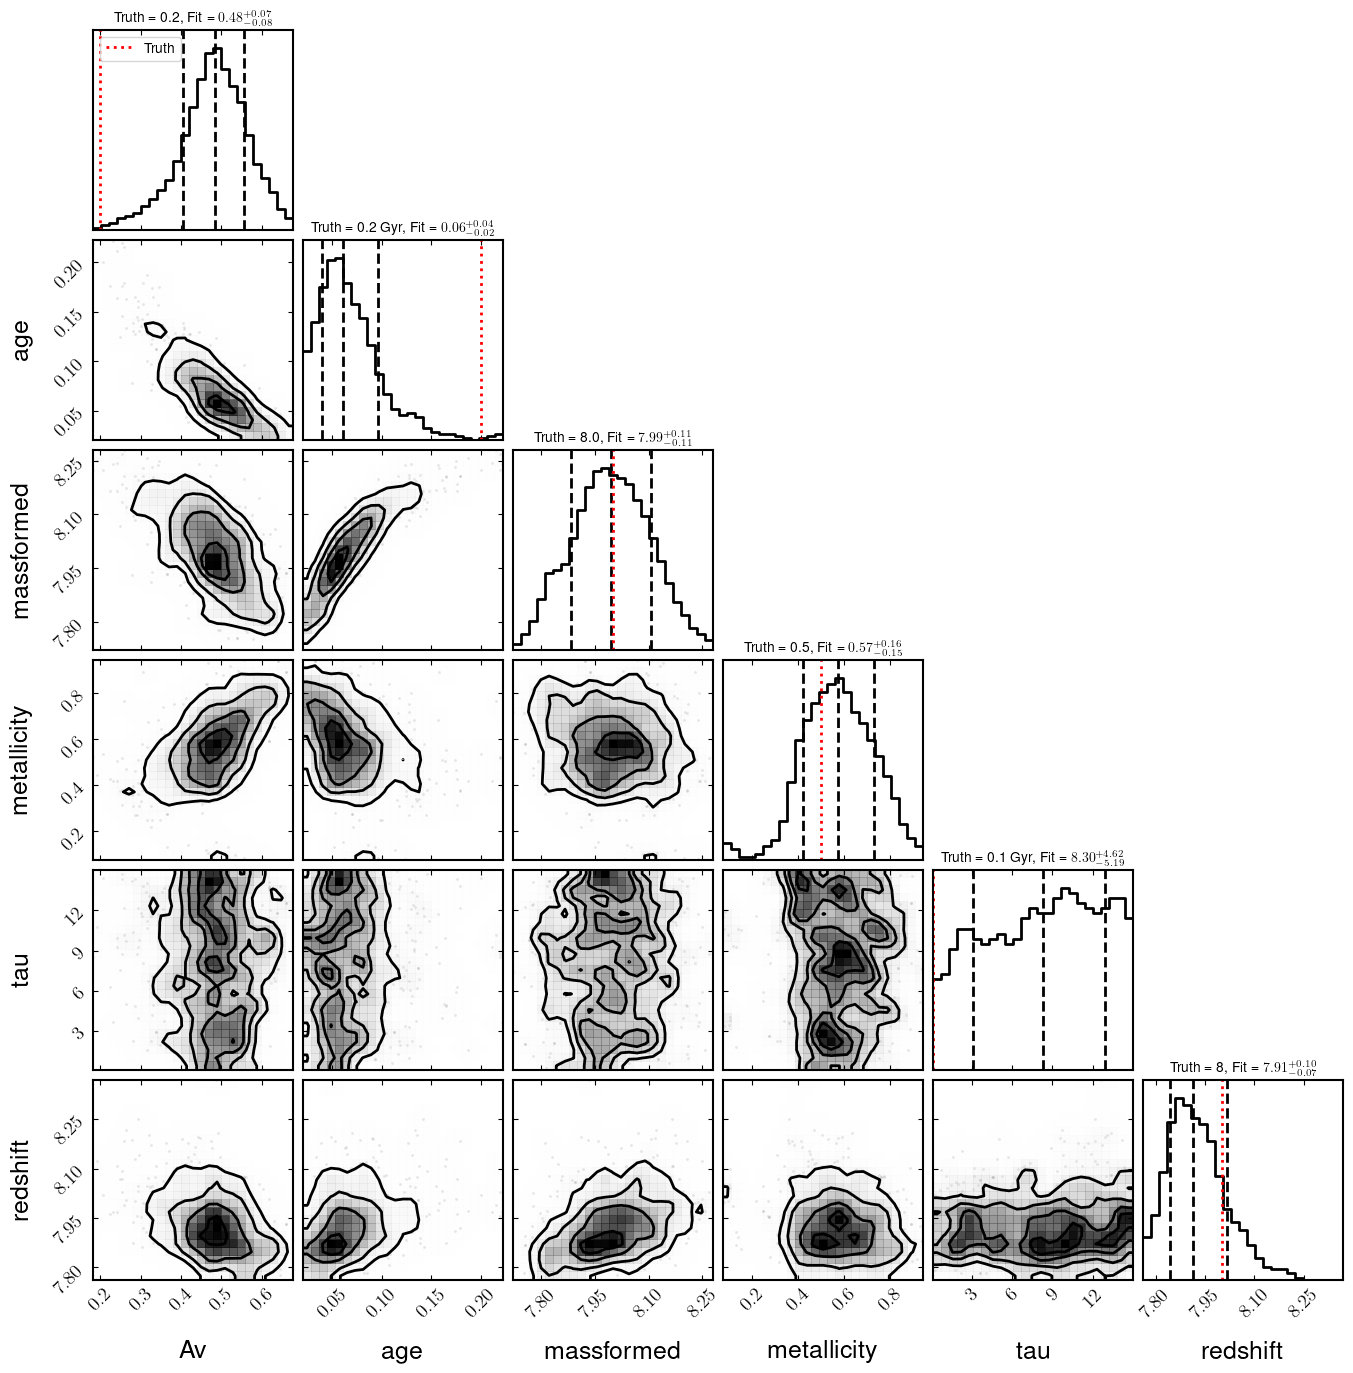

In [47]:
samples = np.copy(fit.posterior.samples2d)

truth = [Av,max_age.to(Gyr),np.log10(stellar_mass),(10**log10z)/0.02,tau.to(Gyr),z]
titles = ['Truth = '+str(value)+', Fit' for value in truth]
labels = [label.split(':')[1] for label in fit.fitted_model.params[:-1]]+['redshift']

# Make the corner plot
fig= corner.corner(samples, labels=labels, titles = titles,quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 10},
                    smooth=1., smooth1d=1., bins=25)

axes = [0,7,14,21,28,35,42]
for value, axis in zip(truth,axes):
    fig.axes[axis].axvline(value, color = 'red', linestyle = ':',label = 'Truth')
    fig.axes[0].legend()

plt.show()
plt.close(fig)